In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import scipy
import astropy

## Load data

In [2]:
def data_scope(arr, t_arr, t_start, t_stop):
    idxs = np.where((t_arr >= t_start) & (t_arr <= t_stop))[0]
    return arr[idxs]

def spike_scope(spikes, t_arr):
    hists = []
    for spike_train in spikes.item().values():
        hist, _ = np.histogram(spike_train, bins=np.append(t_arr, t_arr[-1] + t_arr[1] - t_arr[0]))
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [3]:
data_path = './Toroidal_topology_grid_cell_data/'

In [4]:
with open(data_path + 'rat_q_sessions.txt') as file:
#with open(data_path + 'rat_r_day1_sessions.txt') as file:
#with open(data_path + 'rat_r_day2_sessions.txt') as file:
#with open(data_path + 'rat_s_sessions.txt') as file:
    sessions = file.readlines()
sessions

['#1,  sleep_box_1,        start=9576, end=18812   \n',
 '#2,  wagon_wheel_1,      start=18977, end=25355   \n',
 '#3,  sleep_box_2,        start=25403, end=27007   \n',
 '#4,  open_field_1,       start=27826, end=31223   \n']

In [5]:
data = {}

In [6]:
f = np.load(data_path + 'rat_q_grid_modules_1_2.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']

t_start, t_stop = 27826, 31223
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)

data['rat_q'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2}}

In [7]:
f = np.load(data_path + 'rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 7457, 14778
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day1'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

# can add second slice (valid times) 14890, 16045 here

In [8]:
f = np.load(data_path + 'rat_r_day2_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 10617, 13004
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day2'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

In [9]:
f = np.load(data_path + 'rat_s_grid_modules_1.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']

t_start, t_stop = 9939, 12363
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)

data['rat_s'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1}}

## Create ratemaps

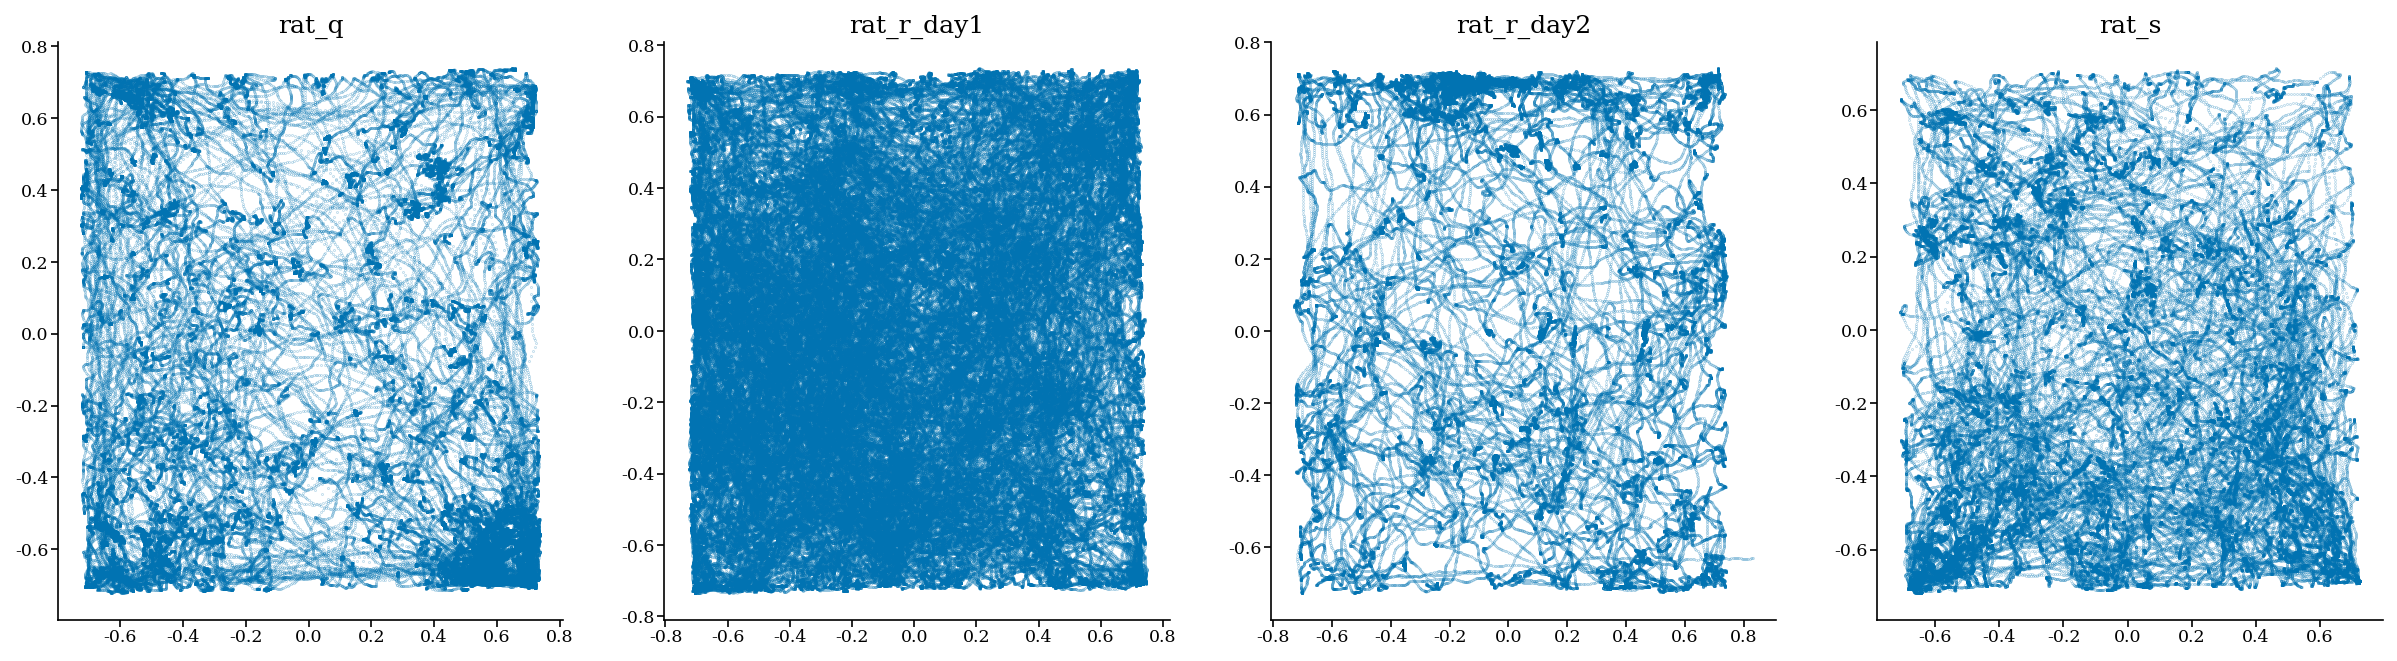

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for i, (rat, rat_data) in enumerate(data.items()):
    axs[i].scatter(rat_data['x'], rat_data['y'], s=0.01)
    axs[i].set_title(rat)

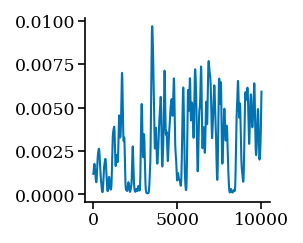

In [11]:
import scipy.ndimage
speed=np.diff(x)**2 + np.diff(y)**2
speed=np.sqrt(speed)
smooth_speed = scipy.ndimage.gaussian_filter1d(speed, 30)
plt.plot(smooth_speed[:10000])

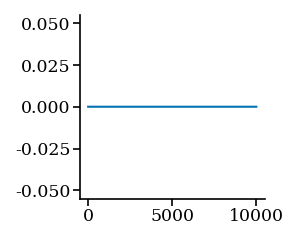

In [12]:
# 1d convolve with gaussian kernel
spikes1_smoothed = scipy.ndimage.gaussian_filter1d(spikes1.astype(np.float32), 30)
#plt.plot(spikes1_smoothed[0,:10000])
#plt.plot(smooth_speed[:10000]*5)
plt.plot(spikes1_smoothed[0,10000] * smooth_speed[:10000])

In [13]:
# calculate cosine similarity for each time point
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(spikes1_smoothed.T, spikes1_smoothed.T[:1])
rel_angle = cos_sim[:,0]

In [14]:
res = 32
all_ratemaps = []
for rat_i, data_i in data.items():
    x, y = data_i['x'], data_i['y']
    for module_j, spikes_j in data_i['modules'].items():
        ratemaps_ij = scipy.stats.binned_statistic_2d(x, y, spikes_j, bins=res).statistic
        all_ratemaps.append(ratemaps_ij)

In [15]:
def multiimshow(zz, figsize=(1,1), normalize=True, add_colorbar=True, rect=(0,0,1,0.87), axes_pad=0.05, **kwargs):
    # prepare figure
    ncols = int(np.ceil(np.sqrt(zz.shape[0])))
    nrows = int(round(np.sqrt(zz.shape[0])))
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=figsize)
    if add_colorbar and normalize:
        grid = ImageGrid(fig, rect=rect, nrows_ncols=(nrows, ncols), axes_pad=axes_pad, cbar_mode='single', cbar_location='right', cbar_pad=0.1, cbar_size='5%')
    else:
        grid = ImageGrid(fig, rect=rect, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)
    vmin, vmax = (np.nanmin(zz), np.nanmax(zz)) if normalize else (None, None)
    # plot response maps using imshow
    for ax, data in zip(grid, zz):
        im = ax.imshow(data, vmin=vmin, vmax=vmax, **kwargs)
    [ax.axis('off') for ax in grid]
    fig.colorbar(im, cax=grid.cbar_axes[0]) if (normalize and add_colorbar) else None
    return fig, grid.axes_all

## Calculate grid statistics

In [16]:
import spatial_maps as sm
ratemaps = all_ratemaps[2]
ratemaps = np.array([astropy.convolution.convolve(ratemaps[i], astropy.convolution.Gaussian2DKernel(2)) for i in range(ratemaps.shape[0])])
center_peaks = np.array([sm.find_peaks(ratemaps[i])[0] for i in range(ratemaps.shape[0])])


acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in ratemaps])
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
grid_score = np.array([sm.gridness(ratemap) for ratemap in ratemaps])
# get the most common spacing
bins=25
hist, bin_edges = np.histogram(spacings, bins=bins)
spacing = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2
hist, bin_edges = np.histogram(thetas, bins=bins)
theta = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2

from methods import Hexagon, HexagonalGCs
radius = spacing/np.sqrt(3) # spacing is peak-to-peak distance
orientation = theta*180/np.pi - 15 # theta is angle from x-axis
hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)
hexagon.set_phases(hexagon.unit_cell.wrap(center_peaks-res/2)) # WRAPPY?
center_peaks = hexagon.phases.detach().numpy() + res/2
print(f"Radius: {radius}, Orientation: {orientation}")

Radius: 7.169120261499953, Orientation: -4.869006752597977


In [17]:
len(all_ratemaps)
[len(ratemaps_i) for ratemaps_i in all_ratemaps]

[97, 66, 166, 168, 149, 189, 172, 183, 140]

Text(0.5, 1.0, 'Grid Score')

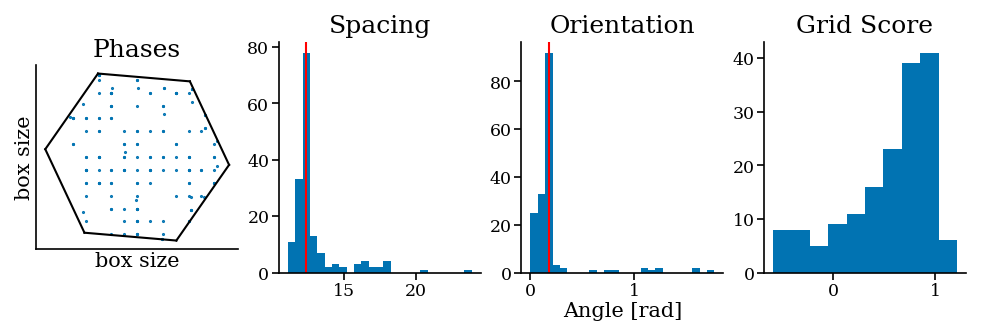

In [18]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 2))
axs[0].scatter(*(center_peaks-res/2).T)
# axs[0].set_xlim(-res/2, res/2)
# axs[0].set_ylim(-res/2, res/2)
hexagon.unit_cell.plot(fig, axs[0], color='black')#, center=np.zeros(2)+res/2-1)
#ax.scatter(*(center_peaks-res/2).T, color='green', alpha=.2)
axs[0].set_title('Phases')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal')
axs[0].set_xlabel('box size')
axs[0].set_ylabel('box size')
axs[1].hist(spacings, bins=bins)
axs[1].axvline(spacing, color='r')
axs[1].set_title('Spacing')
axs[2].hist(thetas, bins=bins)
axs[2].axvline(theta, color='r')
axs[2].set_title('Orientation')
axs[2].set_xlabel('Angle [rad]')
axs[3].hist(grid_score)
axs[3].set_title('Grid Score')


(120, (166, 32, 32))

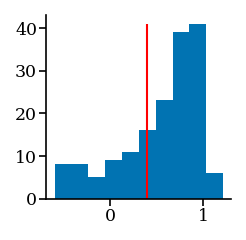

In [19]:
cutoff = 0.4
grid_mask = grid_score > cutoff

count = plt.hist(grid_score)[0]
plt.vlines(cutoff, 0, np.amax(count), "r")
grid_mask.sum(), ratemaps.shape

In [20]:
random_hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)
random_hexagon.set_phases(random_hexagon.unit_cell.wrap(np.around(random_hexagon.unit_cell.sample(len(center_peaks[grid_mask])))))

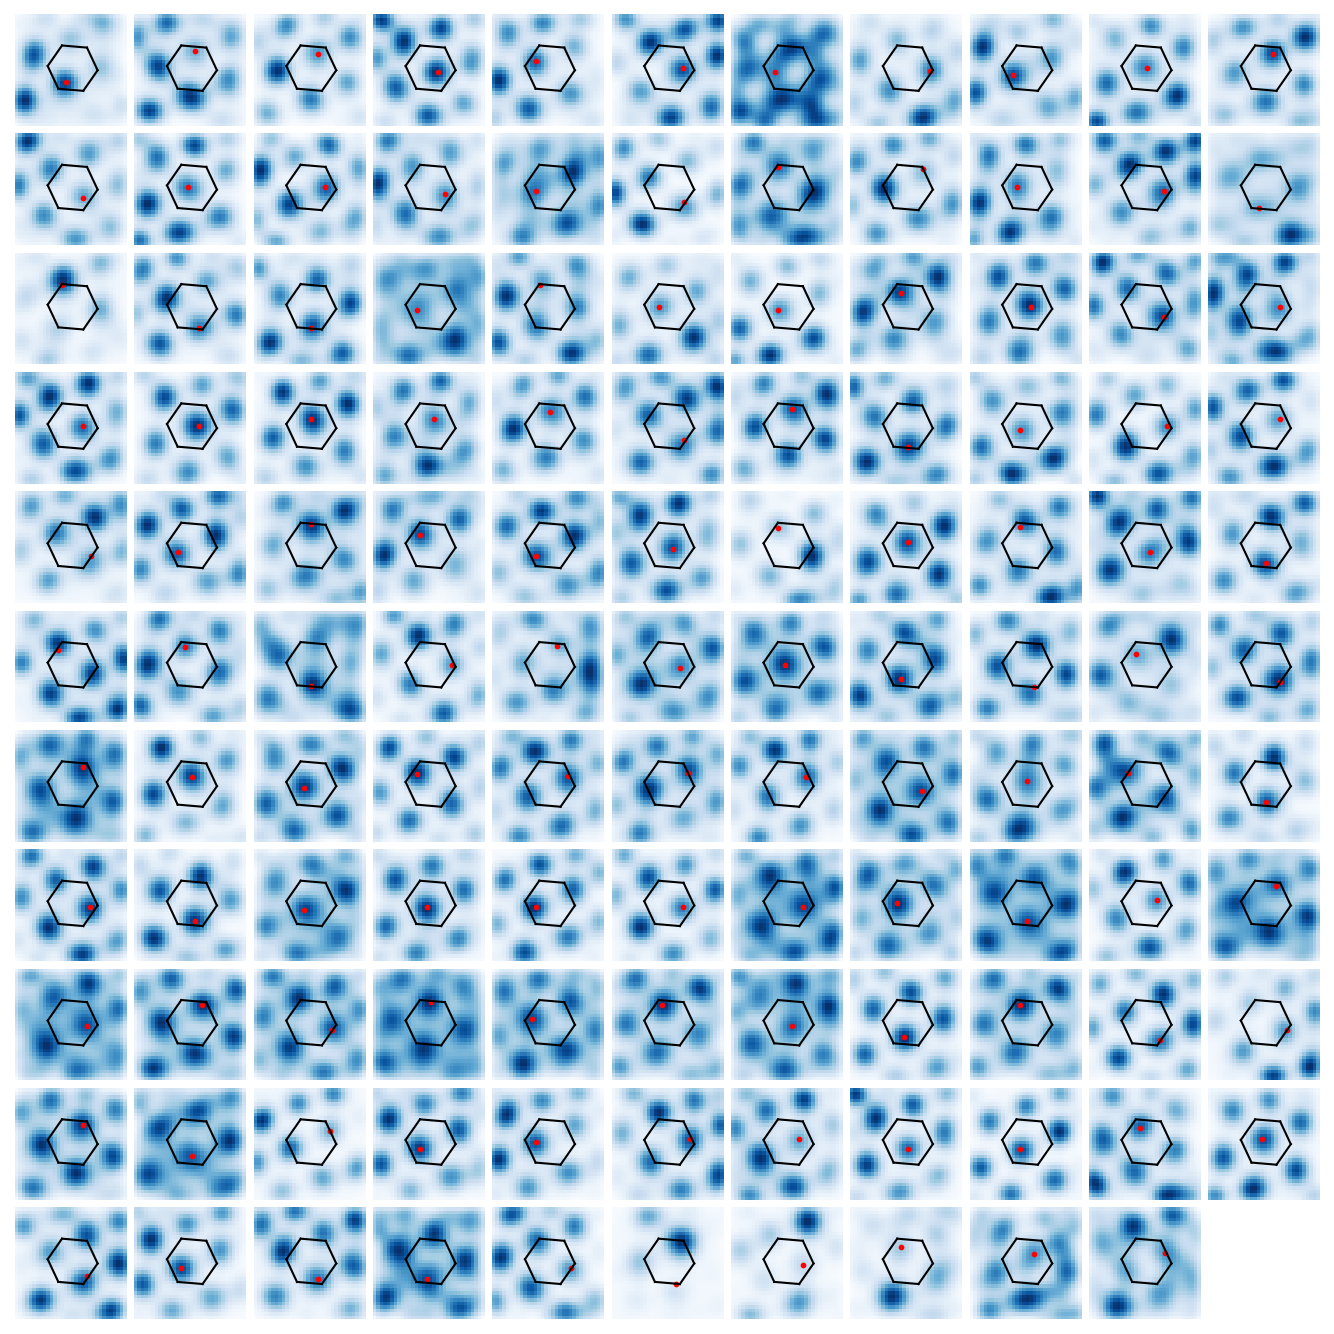

In [21]:
fig, axs = multiimshow(ratemaps[grid_mask].transpose(0,2,1), origin='lower', figsize=(10,10), normalize=False);
for i in range(len(center_peaks[grid_mask])):
    axs[i].scatter(*center_peaks[grid_mask][i], color='red', s=3)
    hexagon.unit_cell.plot(fig, axs[i], center=[res//2, res//2], color='black')

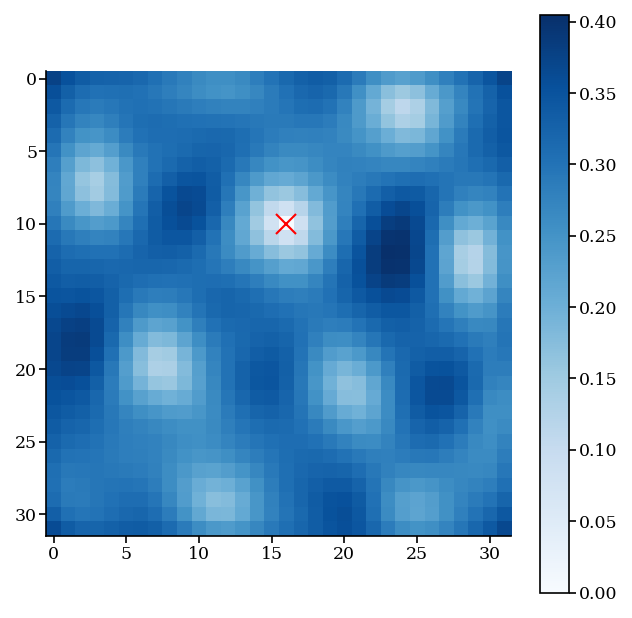

In [22]:
selected_maps = ratemaps[grid_mask]
flat_maps = selected_maps.reshape(selected_maps.shape[0], -1)
dist = np.linalg.norm(flat_maps[:,None] - flat_maps[...,None],axis= 0)

row = 10
col = 16
a = row*32 + col
plt.figure(figsize = (5,5))
plt.imshow(dist[a].reshape(res,res))
plt.plot(col,row, "rx", markersize = 10)
plt.colorbar()

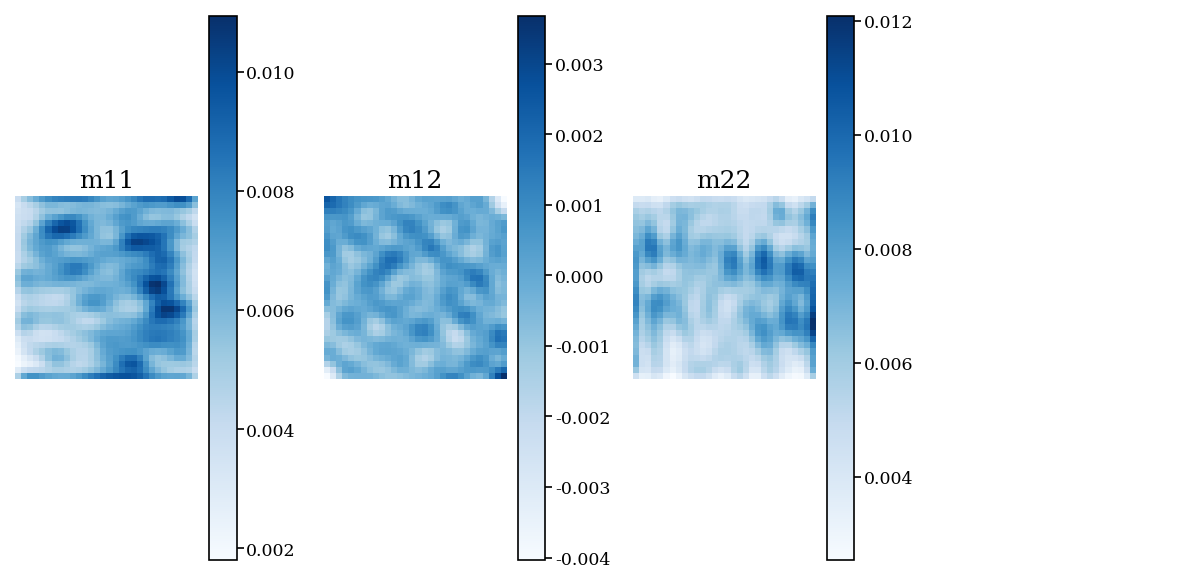

In [23]:
grads = np.array([np.gradient(im) for im in ratemaps])
grads = np.transpose(grads, (0, -2, -1, 1))
grads = grads[:, 1:-1, 1:-1] # remove 1st order boundary term

fig, axs = plt.subplots(1, 4, figsize = (8,4))

m11 = np.sum(grads[...,0]**2, axis = 0)
m22 = np.sum(grads[...,1]**2, axis = 0)
m12 = np.sum(grads[...,0]*grads[...,1], axis = 0)

im1 = axs[0].imshow(m11)
im2 = axs[1].imshow(m12)
im3 = axs[2].imshow(m22)
[ax.axis("off") for ax in axs]
[ax.set_title(title) for ax, title in zip(axs, ["m11", "m12", "m22"])]
[fig.colorbar(im, ax = ax) for ax, im in zip(axs, [im1, im2, im3])]
plt.tight_layout()

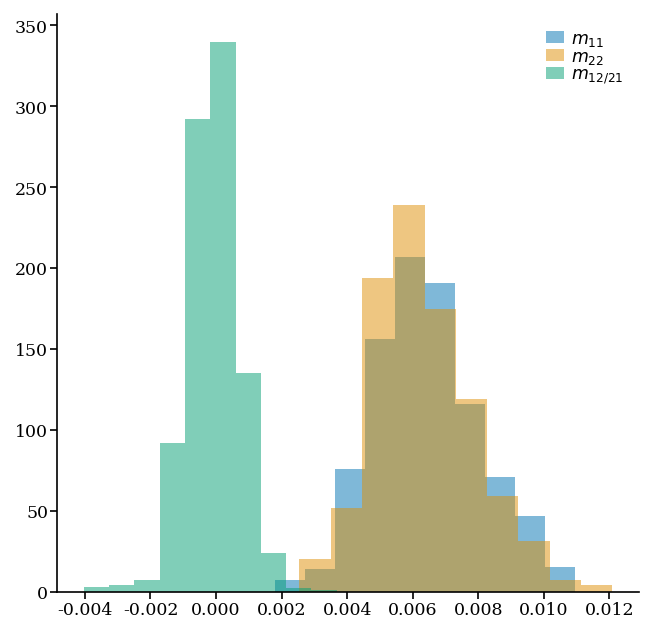

In [24]:
plt.figure(figsize = (5,5))
plt.hist(m11.ravel(), label = "$m_{11}$", alpha = 0.5)
plt.hist(m22.ravel(), label = "$m_{22}$", alpha = 0.5)
plt.hist(m12.ravel(), label = "$m_{12/21}$", alpha = 0.5)
plt.legend(frameon = False)

In [25]:
# shuffled distribution (space)
n_shuffles = 1000

a = []
b = []
c = []

for i in range(n_shuffles):
    abx = np.copy(ratemaps[grid_mask]).reshape(-1, res*res) # shuffle ratemaps
    abx = abx[:, np.random.choice(res*res, size = res*res, replace = False)]
    abx = abx.reshape(-1, res, res)
    grads = np.array([np.gradient(im) for im in abx])

    grads = np.transpose(grads, (0, -2, -1, 1))
    grads = grads[:, 1:-1, 1:-1] # remove 1st order boundary term

    a.append(np.sum(grads[...,0]**2, axis=0))
    b.append(np.sum(grads[...,1]**2, axis = 0))
    c.append(np.sum(grads[...,1]*grads[...,0], axis = 0))

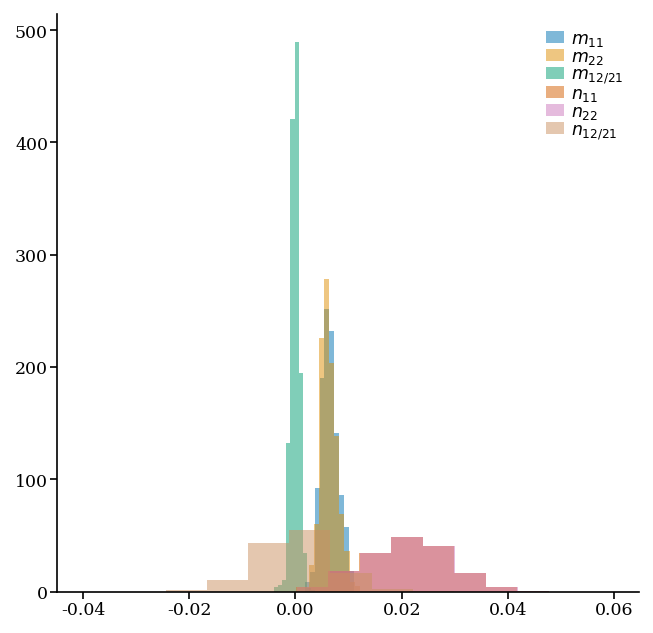

In [26]:
plt.figure(figsize = (5,5))
plt.hist(m11.ravel(), label = "$m_{11}$", alpha = 0.5, density=True)
plt.hist(m22.ravel(), label = "$m_{22}$", alpha = 0.5, density=True)
plt.hist(m12.ravel(), label = "$m_{12/21}$", alpha = 0.5, density=True)

plt.hist(np.array(a).ravel(), label = "$n_{11}$", alpha = 0.5, density=True)
plt.hist(np.array(b).ravel(), label = "$n_{22}$", alpha = 0.5, density=True)
plt.hist(np.array(c).ravel(), label = "$n_{12/21}$", alpha = 0.5, density=True)
plt.legend(frameon = False)

## KDE, Ripley and Grid score of phases

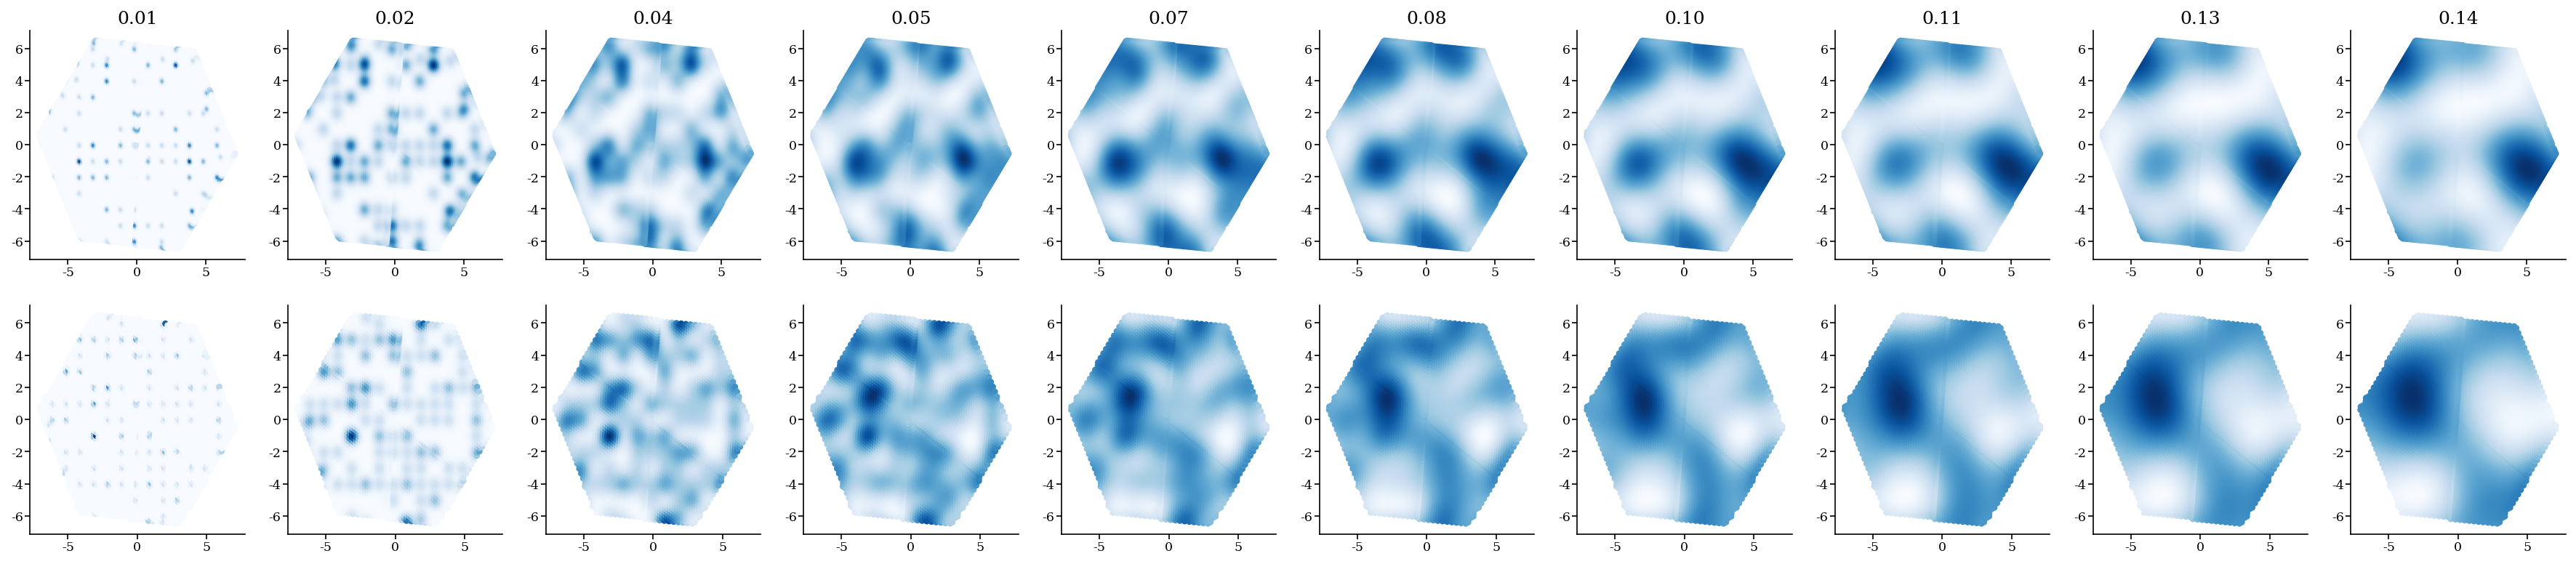

In [27]:
bw_method = np.linspace(0, 0.15, 21)[1:]#hexagon.unit_cell.radius/2/10, 21)[1:]
fig, axs = plt.subplots(nrows=2, ncols=len(bw_method)//2, figsize=(len(bw_method)//2*3, 3*2))
hexagon.set_phases((center_peaks[grid_mask]-res/2)) # WRAPPY?

for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = hexagon.phase_kde(bw_method=r, res=128)
    axs[0,i].scatter(*mesh.T, c=kde, s=10)
    axs[0,i].set_title(f'{r:.2f}')

for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = random_hexagon.phase_kde(bw_method=r, res=64)
    axs[1,i].scatter(*mesh.T, c=kde, s=10)

## Ripleys: Random baseline

100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Text(0, 0.5, "Ripley's H")

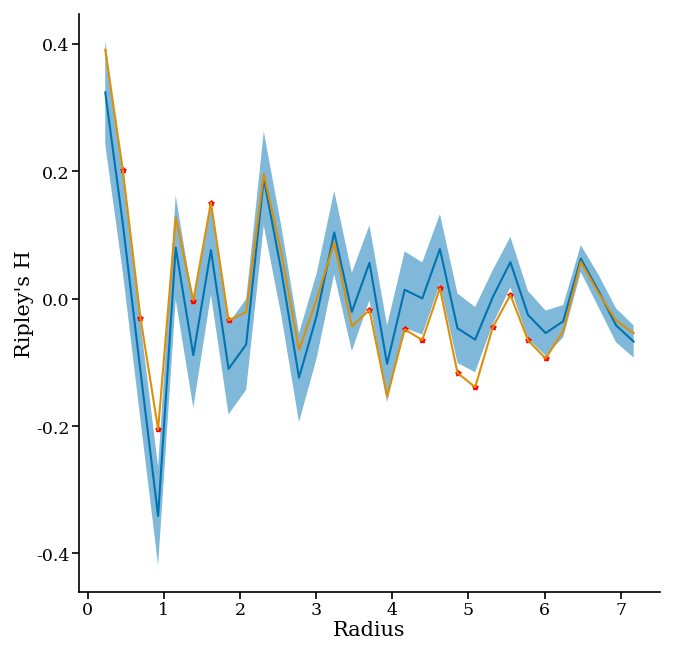

In [95]:
import tqdm

plt.figure(figsize = (5,5))

radii = np.linspace(0, radius, 32)[1:]

random_ripleys = []
for _ in tqdm.trange(100):
    random_hexagon.set_phases(np.around(random_hexagon.unit_cell.sample(len(center_peaks[grid_mask]))))
    random_ripleys_i = [random_hexagon.ripleys(r) for r in radii]
    random_ripleys.append(random_ripleys_i)
random_ripleys = np.array(random_ripleys)

ripleys = [hexagon.ripleys(r) for r in radii]
ripleys = np.array(ripleys)

mu_random = np.mean(random_ripleys, axis = 0)
sigma_random = np.std(random_ripleys,axis=0)

## Ripleys; Hexagonal baseline

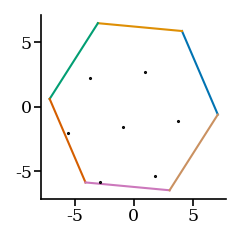

In [162]:
perf_hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)
perf_phases = np.load("./7_perf_phases.npy") # CI optimized
hexagon.unit_cell.plot()
plt.plot(perf_phases[:,0], perf_phases[:,1], "ko",)

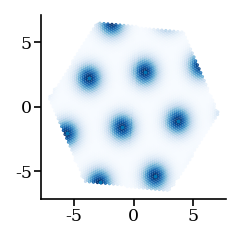

In [218]:
n_copies = 1 + grid_mask.sum()//8
noise_scale = 0
perturbed = perf_phases[:,None] + np.random.normal(0, noise_scale, (7, n_copies, 2))
perturbed = perturbed.reshape(-1, 2)

perf_hexagon.set_phases(perturbed[:grid_mask.sum()])
a, b = perf_hexagon.phase_kde(bw_method = 0.05)[:2]
plt.scatter(*b.T, c = a)
plt.plot(perf_hexagon.phases.detach()[:,0], perf_hexagon.phases.detach()[:,1], "o",)


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


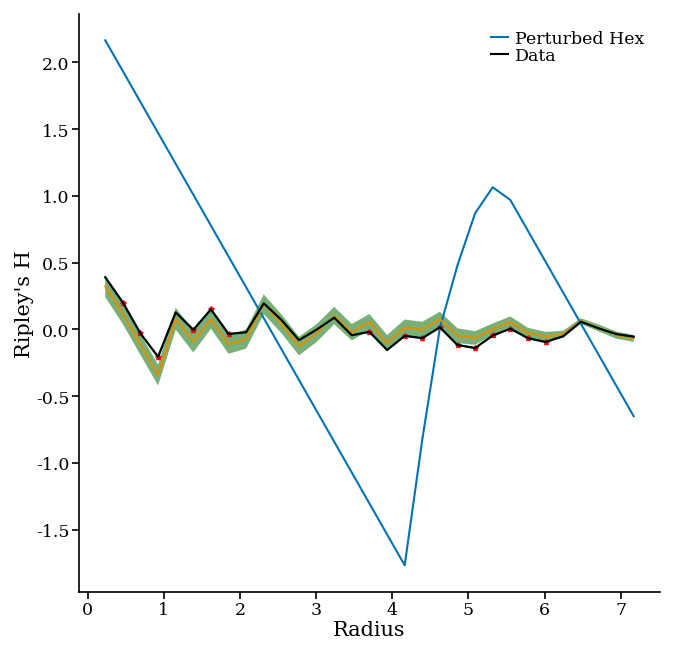

In [219]:
plt.figure(figsize = (5,5))
perturbed_ripleys = []
for _ in tqdm.trange(100):
    
    perturbed = perf_phases[:,None] + np.random.normal(0, noise_scale, (7, n_copies, 2))
    perturbed = perturbed.reshape(-1, 2)
    perf_hexagon.set_phases(perf_hexagon.unit_cell.wrap(np.around(perturbed[:grid_mask.sum()])))

    perturbed_ripleys_i = [perf_hexagon.ripleys(r) for r in radii]
    perturbed_ripleys.append(perturbed_ripleys_i)
perturbed_ripleys = np.array(perturbed_ripleys)


# hexagonal baseline
plt.plot(radii, np.mean(perturbed_ripleys, axis=0), label = "Perturbed Hex")
plt.fill_between(radii, np.percentile(perturbed_ripleys, 2.5, axis=0), np.percentile(perturbed_ripleys, 97.5, axis=0), alpha=0.5)

# random baseline
plt.plot(radii, np.mean(random_ripleys, axis=0))
plt.fill_between(radii, mu_random - 2*sigma_random, mu_random + 2*sigma_random, alpha=0.5)

plt.plot(radii, ripleys)

# data
plt.plot(radii, ripleys, "k", label = "Data")
# plot star where significant

# random baseline
plt.fill_between(radii, mu_random - 2*sigma_random, mu_random + 2*sigma_random, alpha=0.5)
plt.scatter(radii[ripleys > mu_random + 2*sigma_random], 
            ripleys[ripleys > mu_random + 2*sigma_random], color='red', marker='*', s=5)
plt.scatter(radii[ripleys < mu_random -2*sigma_random], 
            ripleys[ripleys < mu_random-2*sigma_random], color='red', marker='*', s=5)

# percentile version
# plt.scatter(radii[ripleys > np.percentile(random_ripleys, 97.5, axis=0)], 
#             ripleys[ripleys > np.percentile(random_ripleys, 97.5, axis=0)], color='red', marker='*', s=5)
# plt.scatter(radii[ripleys < np.percentile(random_ripleys, 2.5, axis=0)], 
#             ripleys[ripleys < np.percentile(random_ripleys, 2.5, axis=0)], color='red', marker='*', s=5)

plt.xlabel('Radius')
plt.ylabel('Ripley\'s H')
plt.legend(frameon = False)

## Rotational symmetry

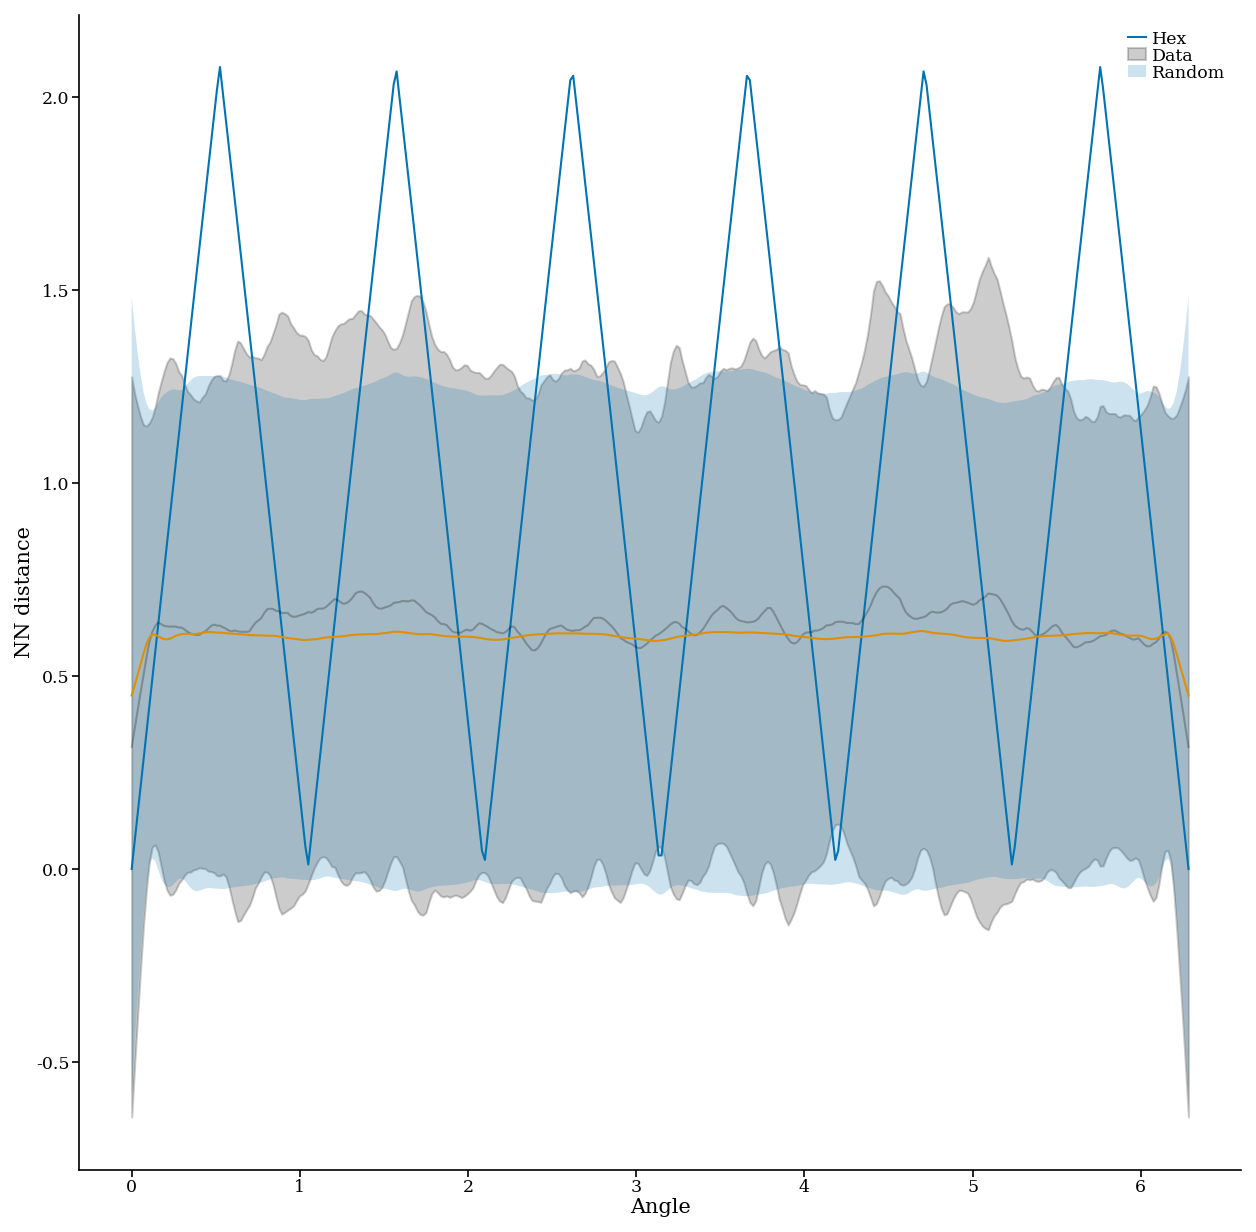

In [237]:
import numpy as np
import matplotlib.pyplot as plt

def rotational_distance(points, n_angles = 360):
    # Function to rotate points by a given angle (in radians) around the origin
    R = lambda t: np.array([[np.cos(t), -np.sin(t)], 
                            [np.sin(t), np.cos(t)]])

    angles = np.linspace(0, 2*np.pi, n_angles)
    nn = np.zeros((len(points), n_angles))

    points = points - np.mean(points, axis = 0)

    for i, theta in enumerate(angles):
        rotated_points = (R(theta)@points.T).T
        dists = scipy.spatial.distance.cdist(points, rotated_points)
        dists[np.arange(len(dists)), np.arange(len(dists))] = np.inf # exlude self-distance
        nn[:,i] = np.amin(dists, axis = -1) # nearest neighbor dist
    return nn, angles

n_shuffles = 100
random_rotation = []
for i in range(n_shuffles):
        random_phases = np.around(random_hexagon.unit_cell.sample(len(center_peaks[grid_mask])))
        
        random_rotation.append(rotational_distance(random_phases)[0])

random_rotation = np.concatenate(random_rotation, axis=0)


nn_dist, angles = rotational_distance(hexagon.phases.detach().numpy())
perf_dist, angles = rotational_distance(perturbed)


plt.figure(figsize = (10,10))
plt.plot(angles, np.mean(perf_dist, axis=0), label="Hex")
# Plot mean of `nn_dist` for "Data", with fill between two standard deviations
mean_nn = np.mean(nn_dist, axis=0)
std_nn = np.std(nn_dist, axis=0)
plt.plot(angles, mean_nn, color="k", alpha=0.25)
plt.fill_between(angles, mean_nn - 2 * std_nn, mean_nn + 2 * std_nn, color="k", alpha=0.2, label = "Data")

# Plot mean of `random_rotation`, with fill between two standard deviations
mean_random = np.mean(random_rotation, axis=0)
std_random = np.std(random_rotation, axis=0)
plt.plot(angles, mean_random)
plt.fill_between(angles, mean_random - 2 * std_random, mean_random + 2 * std_random, alpha=0.2, label = "Random")

plt.xlabel("Angle")
plt.ylabel("NN distance")
# Add legend and show plot
plt.legend(frameon=False)
plt.show()

## Compute neural distances

In [34]:
x = np.linspace(0, 32, res)
y = np.copy(x)
xx, yy = np.meshgrid(x, y)
rr = np.stack((xx.ravel(), yy.ravel()), axis = -1)

dr = np.linalg.norm(rr[:,None] - rr[None], axis = -1)
dg = np.linalg.norm(flat_maps.T[:,None] - flat_maps.T[None], axis = -1)

abx2 = np.reshape(abx, (-1, res*res)).T
dn = np.linalg.norm(abx2[:,None] - abx2[None], axis = -1)

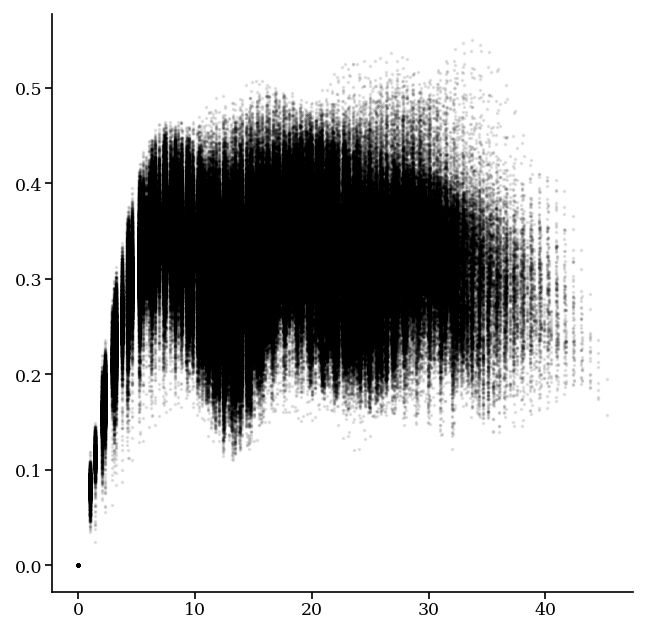

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(dr.ravel(), dg.ravel(), alpha = 0.05, s = 0.5, c = "k")


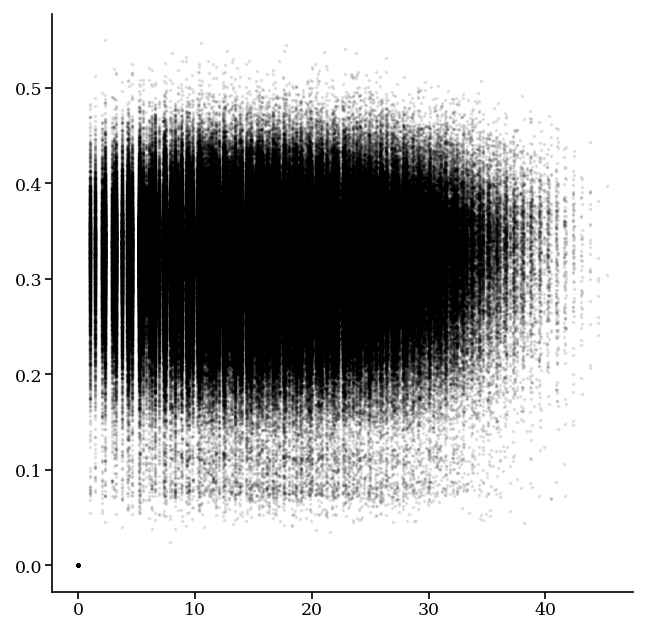

In [36]:
plt.figure(figsize=(5,5))
plt.scatter(dr.ravel(), dn.ravel(), alpha = 0.05, s = 0.5, c = "k")